In [2]:
#!/usr/bin/env python3
"""
01_fetch_spaces.py
Fetch Snapshot "spaces" universe (DAO platforms) with light metadata for coverage-based selection.

Output:
- data/processed/spaces_universe.csv

Run:
python 01_fetch_spaces.py
"""

from __future__ import annotations
import os
import time
import random
from dataclasses import dataclass
from typing import Any, Dict, List, Optional

import requests
import pandas as pd


SNAPSHOT_GQL = "https://hub.snapshot.org/graphql"
OUT_DIR = "data/processed"
OUT_PATH = os.path.join(OUT_DIR, "spaces_universe.csv")


Q_SPACES = """
query Spaces($first: Int!, $skip: Int!) {
  spaces(first: $first, skip: $skip, orderBy: "created", orderDirection: desc) {
    id
    name
    network
    symbol
    private
    created
    # These fields may or may not exist depending on API version.
    followersCount
    proposalsCount
  }
}
"""


@dataclass
class GQLClient:
    endpoint: str = SNAPSHOT_GQL
    timeout: int = 60
    max_retries: int = 6
    backoff_base: float = 1.25

    def post(self, query: str, variables: Dict[str, Any]) -> Dict[str, Any]:
        payload = {"query": query, "variables": variables}
        for attempt in range(1, self.max_retries + 1):
            try:
                r = requests.post(self.endpoint, json=payload, timeout=self.timeout)
                r.raise_for_status()
                j = r.json()
                if "errors" in j:
                    raise RuntimeError(j["errors"][:1])
                return j["data"]
            except Exception as e:
                if attempt == self.max_retries:
                    raise
                sleep_s = (self.backoff_base ** attempt) + random.random()
                print(f"[WARN] attempt {attempt} failed: {e} | sleep {sleep_s:.2f}s")
                time.sleep(sleep_s)
        raise RuntimeError("Retries exhausted")


def fetch_all_spaces(page_size: int = 1000) -> List[Dict[str, Any]]:
    client = GQLClient()
    all_rows: List[Dict[str, Any]] = []
    skip = 0

    while True:
        data = client.post(Q_SPACES, {"first": page_size, "skip": skip})
        batch = data.get("spaces", []) or []
        if not batch:
            break
        all_rows.extend(batch)
        skip += page_size
        time.sleep(0.15)

    return all_rows


def main() -> None:
    os.makedirs(OUT_DIR, exist_ok=True)
    rows = fetch_all_spaces()

    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("No spaces returned. Check connectivity / endpoint.")

    # Normalize numeric columns if present
    for col in ["followersCount", "proposalsCount", "created"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.sort_values("created", ascending=True).reset_index(drop=True)

    df.to_csv(OUT_PATH, index=False)
    print(f"[OK] saved {OUT_PATH} | rows={len(df)}")
    print("[INFO] columns:", list(df.columns))


if __name__ == "__main__":
    main()


[OK] saved data/processed\spaces_universe.csv | rows=90310
[INFO] columns: ['id', 'name', 'network', 'symbol', 'private', 'created', 'followersCount', 'proposalsCount']


knee rank: 1739 coverage: 0.5230741455227499


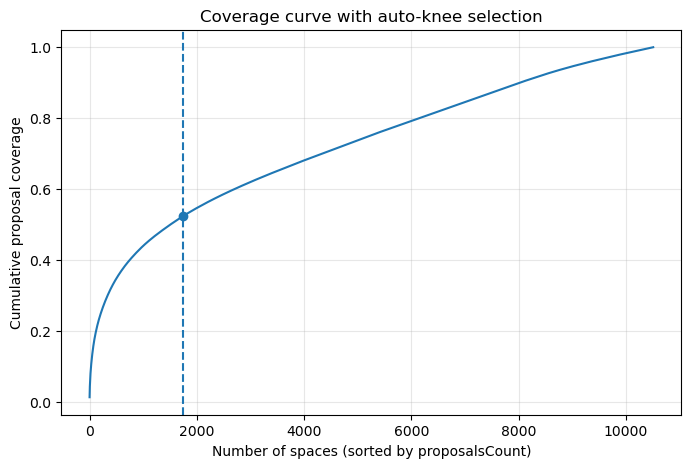

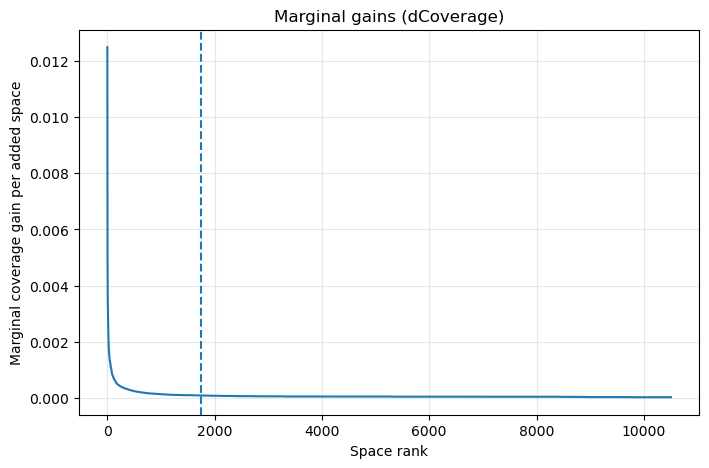

(1739,
 ['cakevote.eth',
  'snapshot.dcl.eth',
  'cvx.eth',
  'index-coop.eth',
  'aladdindao.eth',
  'veclev.eth',
  'hvax.eth',
  'sdcrv-gov.eth',
  'balancer.eth',
  'sdbal.eth'])

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("data/processed/spaces_universe.csv")
df["proposalsCount"] = pd.to_numeric(df["proposalsCount"], errors="coerce")
df = df.dropna(subset=["proposalsCount"]).copy()
df = df[df["proposalsCount"] >= 10].sort_values("proposalsCount", ascending=False).reset_index(drop=True)

df["cum_proposals"] = df["proposalsCount"].cumsum()
df["cum_coverage"] = df["cum_proposals"] / df["proposalsCount"].sum()

y = df["cum_coverage"].to_numpy()
x = np.linspace(0, 1, len(y))

def knee_by_max_distance(cum_coverage):
    n = len(cum_coverage)
    x = np.linspace(0, 1, n)
    y = cum_coverage
    x0, y0 = 0.0, float(y[0])
    x1, y1 = 1.0, float(y[-1])
    numerator = np.abs((y1-y0)*x - (x1-x0)*y + x1*y0 - y1*x0)
    denom = np.sqrt((y1-y0)**2 + (x1-x0)**2)
    d = numerator / (denom + 1e-12)
    return int(np.argmax(d[:-1]))

knee_idx = knee_by_max_distance(y)
k = knee_idx + 1
cov = y[knee_idx]
print("knee rank:", k, "coverage:", cov)

# Plot 1: coverage curve
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(y)+1), y)
plt.axvline(k, linestyle="--")
plt.scatter([k], [cov])
plt.xlabel("Number of spaces (sorted by proposalsCount)")
plt.ylabel("Cumulative proposal coverage")
plt.title("Coverage curve with auto-knee selection")
plt.grid(True, alpha=0.3)
plt.show()

# Plot 2: marginal gain
dy = np.diff(np.insert(y, 0, 0.0))
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(dy)+1), dy)
plt.axvline(k, linestyle="--")
plt.xlabel("Space rank")
plt.ylabel("Marginal coverage gain per added space")
plt.title("Marginal gains (dCoverage)")
plt.grid(True, alpha=0.3)
plt.show()

selected_spaces = df.loc[:knee_idx, "id"].tolist()
len(selected_spaces), selected_spaces[:10]


In [4]:
# knee_idx 是 0-based index
boundary_space = df.iloc[knee_idx]

print(f"""
Boundary space (knee):
---------------------
Rank (1-based): {knee_idx + 1}
Space ID:       {boundary_space['id']}
Proposals:      {boundary_space['proposalsCount']}
Followers:      {boundary_space.get('followersCount', 'NA')}
Cumulative cov: {boundary_space['cum_coverage']:.3f}
""")




Boundary space (knee):
---------------------
Rank (1-based): 1739
Space ID:       cryptohipposvote.eth
Proposals:      29
Followers:      288
Cumulative cov: 0.523



In [5]:
# 对比三个边界
idx_80 = df[df["cum_coverage"] >= 0.80].index[0]
idx_85 = df[df["cum_coverage"] >= 0.85].index[0]

compare = df.loc[[knee_idx, idx_80, idx_85],
                 ["id", "proposalsCount", "followersCount", "cum_coverage"]]
compare


,id,proposalsCount,followersCount,cum_coverage
1738,cryptohipposvote.eth,29,288,0.523074
6147,gangshetzakhar.eth,16,1,0.800034
7082,fumk51.eth,16,1,0.850051


In [2]:
import pandas as pd

# 读取你之前保存的 Snapshot universe 数据
df = pd.read_csv("data/processed/spaces_universe.csv")

# 看一眼，确认 df 已经存在
df.head()


,id,name,network,symbol,private,created,followersCount,proposalsCount
0,bonustrack.eth,Hi,1,TICKET,True,1605388716,2,2
1,fabien.eth,Fabien,1,ETH,False,1605976603,971,467
2,ichi.eth,ichi.farm,1,ICHIPOWAH,False,1605995400,58,60
3,loyalfinance.eth,loyal.finance,1,rLYL,False,1606038518,0,2
4,damflux.eth,FLUX,1,FLUX,False,1606079425,6,2


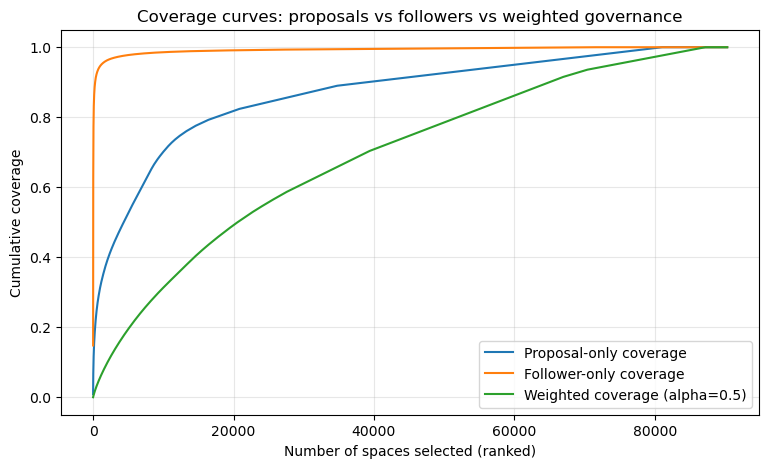

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 0) 清洗
df2 = df.copy()
df2["proposalsCount"] = pd.to_numeric(df2["proposalsCount"], errors="coerce")
df2["followersCount"] = pd.to_numeric(df2["followersCount"], errors="coerce")

# 如果 followersCount 为空，可以先填 0（但建议记录 missing 比例）
df2["followersCount"] = df2["followersCount"].fillna(0)

# 只保留有 proposalsCount 的 space（否则 activity 无意义）
df2 = df2.dropna(subset=["proposalsCount"]).copy()

# 1) log transform
df2["lp"] = np.log1p(df2["proposalsCount"])
df2["lf"] = np.log1p(df2["followersCount"])

# 2) robust standardization（用 median / IQR）
def robust_z(x: pd.Series) -> pd.Series:
    med = x.median()
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = (q3 - q1) if (q3 - q1) != 0 else 1.0
    return (x - med) / iqr

df2["lp_z"] = robust_z(df2["lp"])
df2["lf_z"] = robust_z(df2["lf"])

# 3) governance score (alpha 可调)
alpha = 0.5
df2["gov_score"] = alpha * df2["lp_z"] + (1 - alpha) * df2["lf_z"]

# 4) 按 score 排序并计算 coverage
df2 = df2.sort_values("gov_score", ascending=False).reset_index(drop=True)

# 注意：score 可能有负数，不适合直接当“权重”累加。
# 解决：把 score 平移为正数（不改变排序），再算 coverage。
eps = 1e-9
shift = -df2["gov_score"].min() + eps
df2["gov_weight"] = df2["gov_score"] + shift

total_w = df2["gov_weight"].sum()
df2["cum_weight"] = df2["gov_weight"].cumsum()
df2["cum_cov_weighted"] = df2["cum_weight"] / total_w

# 5) 同时计算 proposal-only / follower-only coverage（用于对比）
df_p = df2.sort_values("proposalsCount", ascending=False).reset_index(drop=True)
df_p["cum_cov_p"] = df_p["proposalsCount"].cumsum() / df_p["proposalsCount"].sum()

df_f = df2.sort_values("followersCount", ascending=False).reset_index(drop=True)
# followers 总和可能为 0（极端情况），做保护
followers_sum = df_f["followersCount"].sum()
df_f["cum_cov_f"] = df_f["followersCount"].cumsum() / (followers_sum if followers_sum > 0 else 1.0)

# 6) 画三条曲线对比
plt.figure(figsize=(9,5))
plt.plot(np.arange(1, len(df_p)+1), df_p["cum_cov_p"].values, label="Proposal-only coverage")
plt.plot(np.arange(1, len(df_f)+1), df_f["cum_cov_f"].values, label="Follower-only coverage")
plt.plot(np.arange(1, len(df2)+1), df2["cum_cov_weighted"].values, label=f"Weighted coverage (alpha={alpha})")
plt.xlabel("Number of spaces selected (ranked)")
plt.ylabel("Cumulative coverage")
plt.title("Coverage curves: proposals vs followers vs weighted governance")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [4]:
import numpy as np

def knee_by_max_distance(cum_coverage: np.ndarray) -> int:
    """
    Find knee index using maximum distance to diagonal.
    cum_coverage must be monotonic increasing in [0,1].
    Return: 0-based index
    """
    n = len(cum_coverage)
    x = np.linspace(0, 1, n)
    y = cum_coverage

    x0, y0 = 0.0, y[0]
    x1, y1 = 1.0, y[-1]

    numerator = np.abs((y1 - y0)*x - (x1 - x0)*y + x1*y0 - y1*x0)
    denom = np.sqrt((y1 - y0)**2 + (x1 - x0)**2)
    d = numerator / (denom + 1e-12)

    return int(np.argmax(d[:-1]))


In [5]:
# proposal-only 排序
df_p = df.sort_values("proposalsCount", ascending=False).reset_index(drop=True)
df_p["cum_cov_p"] = df_p["proposalsCount"].cumsum() / df_p["proposalsCount"].sum()

knee_p = knee_by_max_distance(df_p["cum_cov_p"].values)
b_p = df_p.iloc[knee_p]

print("""
Proposal-only knee
------------------
Rank (1-based): {}
Space ID:       {}
Proposals:      {}
Followers:      {}
Coverage:       {:.3f}
""".format(
    knee_p + 1,
    b_p["id"],
    int(b_p["proposalsCount"]),
    int(b_p["followersCount"]),
    b_p["cum_cov_p"]
))



Proposal-only knee
------------------
Rank (1-based): 14465
Space ID:       yangzs.eth
Proposals:      5
Followers:      4
Coverage:       0.774



In [6]:
# follower-only 排序
df_f = df.sort_values("followersCount", ascending=False).reset_index(drop=True)

total_f = df_f["followersCount"].sum()
df_f["cum_cov_f"] = df_f["followersCount"].cumsum() / (total_f if total_f > 0 else 1)

knee_f = knee_by_max_distance(df_f["cum_cov_f"].values)
b_f = df_f.iloc[knee_f]

print("""
Follower-only knee
------------------
Rank (1-based): {}
Space ID:       {}
Proposals:      {}
Followers:      {}
Coverage:       {:.3f}
""".format(
    knee_f + 1,
    b_f["id"],
    int(b_f["proposalsCount"]),
    int(b_f["followersCount"]),
    b_f["cum_cov_f"]
))



Follower-only knee
------------------
Rank (1-based): 2082
Space ID:       valkyriesworld.eth
Proposals:      0
Followers:      59
Coverage:       0.963



In [7]:
# weighted governance 排序（你之前已经算好 gov_weight / cum_cov_weighted）
df_w = df2.sort_values("gov_score", ascending=False).reset_index(drop=True)

shift = -df_w["gov_score"].min() + 1e-9
df_w["gov_weight"] = df_w["gov_score"] + shift
df_w["cum_cov_w"] = df_w["gov_weight"].cumsum() / df_w["gov_weight"].sum()

knee_w = knee_by_max_distance(df_w["cum_cov_w"].values)
b_w = df_w.iloc[knee_w]

print("""
Weighted governance knee
-----------------------
Rank (1-based): {}
Space ID:       {}
Proposals:      {}
Followers:      {}
Weighted cov:   {:.3f}
""".format(
    knee_w + 1,
    b_w["id"],
    int(b_w["proposalsCount"]),
    int(b_w["followersCount"]),
    b_w["cum_cov_w"]
))



Weighted governance knee
-----------------------
Rank (1-based): 27281
Space ID:       bnb666.eth
Proposals:      0
Followers:      7
Weighted cov:   0.584



In [8]:
compare_knees = pd.DataFrame([
    {"type": "proposal-only", **b_p[["id","proposalsCount","followersCount"]].to_dict(), "coverage": b_p["cum_cov_p"]},
    {"type": "follower-only", **b_f[["id","proposalsCount","followersCount"]].to_dict(), "coverage": b_f["cum_cov_f"]},
    {"type": "weighted", **b_w[["id","proposalsCount","followersCount"]].to_dict(), "coverage": b_w["cum_cov_w"]},
])

compare_knees


,type,id,proposalsCount,followersCount,coverage
0,proposal-only,yangzs.eth,5,4,0.774223
1,follower-only,valkyriesworld.eth,0,59,0.963496
2,weighted,bnb666.eth,0,7,0.583739


Universe after filter: 10505 spaces | min proposals = 10

[Proposal-only] boundaries
  target=0.80 | rank=6148 | id=gangshetzakhar.eth | proposals=16 | followers=1 | cov=0.800034
  target=0.85 | rank=7083 | id=fumk51.eth | proposals=16 | followers=1 | cov=0.850051

[Follower-only] boundaries
  target=0.80 | rank=44 | id=gnosis.eth | proposals=243 | followers=12164 | cov=0.802152
  target=0.85 | rank=68 | id=shapeshiftdao.eth | proposals=238 | followers=6620 | cov=0.850351

[Weighted (alpha=0.5)] boundaries
  target=0.80 | rank=6165 | id=octantdao.eth | proposals=14 | followers=7 | cov=0.800042
  target=0.85 | rank=7036 | id=trhghfg.eth | proposals=16 | followers=1 | cov=0.850014

[KNEE points]
  Proposal-only knee | rank=1739 | id=cryptohipposvote.eth | proposals=29 | followers=288 | cov=0.523074
  Follower-only knee | rank=441 | id=zombiezdao.eth | proposals=45 | followers=325 | cov=0.959872
  Weighted knee      | rank=3045 | id=beareatssalmon.eth | proposals=18 | followers=14 | cov=0

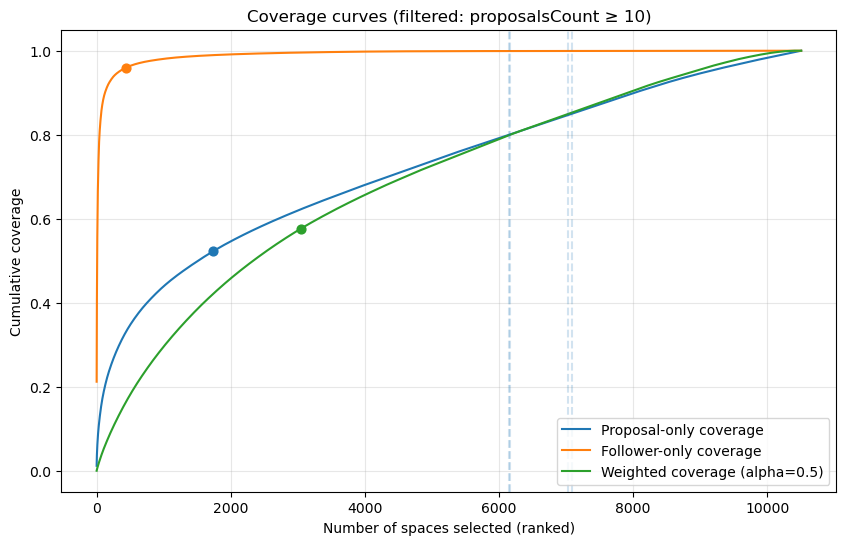

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Parameters (你可以改)
# -----------------------------
min_proposals = 10     # 关键：治理存在性门槛（建议 10）
alpha = 0.5            # proposal vs follower 权重
show_knee = True       # 是否在图上标 knee 点
targets = [0.80, 0.85] # 你关心的 coverage 阈值

# -----------------------------
# 1) Prepare + Clean (统一 universe)
# -----------------------------
df_u = df.copy()
df_u["proposalsCount"] = pd.to_numeric(df_u["proposalsCount"], errors="coerce")
df_u["followersCount"] = pd.to_numeric(df_u["followersCount"], errors="coerce")

# followersCount 缺失按 0（但你可以记录缺失比例用于论文）
df_u["followersCount"] = df_u["followersCount"].fillna(0)

# 丢掉 proposalsCount 缺失
df_u = df_u.dropna(subset=["proposalsCount"]).copy()

# 关键：治理存在性门槛（避免 proposals=0/1 的长尾污染 knee 与 coverage）
df_u = df_u[df_u["proposalsCount"] >= min_proposals].copy()

print(f"Universe after filter: {len(df_u)} spaces | min proposals = {df_u['proposalsCount'].min()}")

# -----------------------------
# 2) Helper: robust z-score
# -----------------------------
def robust_z(x: pd.Series) -> pd.Series:
    med = x.median()
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = (q3 - q1)
    if pd.isna(iqr) or iqr == 0:
        iqr = 1.0
    return (x - med) / iqr

# -----------------------------
# 3) Helper: knee detection (max distance to diagonal)
# -----------------------------
def knee_by_max_distance(cum_coverage: np.ndarray) -> int:
    n = len(cum_coverage)
    if n < 3:
        return max(0, n - 1)

    x = np.linspace(0, 1, n)
    y = cum_coverage.astype(float)

    # Line between endpoints
    x0, y0 = 0.0, float(y[0])
    x1, y1 = 1.0, float(y[-1])

    numerator = np.abs((y1 - y0) * x - (x1 - x0) * y + x1 * y0 - y1 * x0)
    denom = np.sqrt((y1 - y0) ** 2 + (x1 - x0) ** 2)
    d = numerator / (denom + 1e-12)

    return int(np.argmax(d[:-1]))

# -----------------------------
# 4) Proposal-only coverage curve (同一 universe)
# -----------------------------
df_p = df_u.sort_values("proposalsCount", ascending=False).reset_index(drop=True)
df_p["cum_cov_p"] = df_p["proposalsCount"].cumsum() / df_p["proposalsCount"].sum()

# -----------------------------
# 5) Follower-only coverage curve (同一 universe)
# -----------------------------
df_f = df_u.sort_values("followersCount", ascending=False).reset_index(drop=True)
followers_sum = df_f["followersCount"].sum()
df_f["cum_cov_f"] = df_f["followersCount"].cumsum() / (followers_sum if followers_sum > 0 else 1.0)

# -----------------------------
# 6) Weighted governance coverage curve (同一 universe)
#    log1p + robust z + linear combination -> non-negative weight
# -----------------------------
df_w = df_u.copy()
df_w["lp"] = np.log1p(df_w["proposalsCount"])
df_w["lf"] = np.log1p(df_w["followersCount"])

df_w["lp_z"] = robust_z(df_w["lp"])
df_w["lf_z"] = robust_z(df_w["lf"])

df_w["gov_score"] = alpha * df_w["lp_z"] + (1 - alpha) * df_w["lf_z"]
df_w = df_w.sort_values("gov_score", ascending=False).reset_index(drop=True)

# 让权重非负（不改变排序）
eps = 1e-9
shift = -df_w["gov_score"].min() + eps
df_w["gov_weight"] = df_w["gov_score"] + shift

total_w = df_w["gov_weight"].sum()
df_w["cum_cov_w"] = df_w["gov_weight"].cumsum() / (total_w if total_w > 0 else 1.0)

# -----------------------------
# 7) Extract boundary info for targets (80% / 85% 等)
# -----------------------------
def boundary_at(df_curve: pd.DataFrame, cov_col: str, target: float) -> pd.Series:
    idx = df_curve[df_curve[cov_col] >= target].index[0]
    row = df_curve.iloc[idx].copy()
    row["rank_1based"] = idx + 1
    row["target"] = target
    return row

def print_boundaries(name, df_curve, cov_col):
    print(f"\n[{name}] boundaries")
    for t in targets:
        b = boundary_at(df_curve, cov_col, t)
        print(f"  target={t:.2f} | rank={int(b['rank_1based'])} | id={b['id']} | "
              f"proposals={int(b['proposalsCount'])} | followers={int(b['followersCount'])} | cov={float(b[cov_col]):.6f}")

print_boundaries("Proposal-only", df_p, "cum_cov_p")
print_boundaries("Follower-only", df_f, "cum_cov_f")
print_boundaries(f"Weighted (alpha={alpha})", df_w, "cum_cov_w")

# Optional: knee points
if show_knee:
    knee_p = knee_by_max_distance(df_p["cum_cov_p"].values)
    knee_f = knee_by_max_distance(df_f["cum_cov_f"].values)
    knee_w = knee_by_max_distance(df_w["cum_cov_w"].values)

    kp = df_p.iloc[knee_p]
    kf = df_f.iloc[knee_f]
    kw = df_w.iloc[knee_w]

    print("\n[KNEE points]")
    print(f"  Proposal-only knee | rank={knee_p+1} | id={kp['id']} | proposals={int(kp['proposalsCount'])} | followers={int(kp['followersCount'])} | cov={float(df_p.iloc[knee_p]['cum_cov_p']):.6f}")
    print(f"  Follower-only knee | rank={knee_f+1} | id={kf['id']} | proposals={int(kf['proposalsCount'])} | followers={int(kf['followersCount'])} | cov={float(df_f.iloc[knee_f]['cum_cov_f']):.6f}")
    print(f"  Weighted knee      | rank={knee_w+1} | id={kw['id']} | proposals={int(kw['proposalsCount'])} | followers={int(kw['followersCount'])} | cov={float(df_w.iloc[knee_w]['cum_cov_w']):.6f}")

# -----------------------------
# 8) Plot: three curves in one figure
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(df_p)+1), df_p["cum_cov_p"].values, label="Proposal-only coverage")
plt.plot(np.arange(1, len(df_f)+1), df_f["cum_cov_f"].values, label="Follower-only coverage")
plt.plot(np.arange(1, len(df_w)+1), df_w["cum_cov_w"].values, label=f"Weighted coverage (alpha={alpha})")

# draw vertical lines for 80% / 85% on each curve (可选：只画 weighted 也行)
for t in targets:
    # proposal-only
    idx = df_p[df_p["cum_cov_p"] >= t].index[0]
    plt.axvline(idx+1, linestyle="--", alpha=0.2)
    # weighted
    idxw = df_w[df_w["cum_cov_w"] >= t].index[0]
    plt.axvline(idxw+1, linestyle="--", alpha=0.2)

# mark knee points
if show_knee:
    plt.scatter([knee_p+1], [df_p.iloc[knee_p]["cum_cov_p"]], s=40)
    plt.scatter([knee_f+1], [df_f.iloc[knee_f]["cum_cov_f"]], s=40)
    plt.scatter([knee_w+1], [df_w.iloc[knee_w]["cum_cov_w"]], s=40)

plt.xlabel("Number of spaces selected (ranked)")
plt.ylabel("Cumulative coverage")
plt.title(f"Coverage curves (filtered: proposalsCount ≥ {min_proposals})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [10]:
import os, json
import numpy as np
import pandas as pd

# ==========
# 0) Paths
# ==========
OUT_DIR = "data/processed"
os.makedirs(OUT_DIR, exist_ok=True)
OUT_JSON = os.path.join(OUT_DIR, "selected_spaces.json")
OUT_CSV  = os.path.join(OUT_DIR, "selection_report.csv")

# ==========
# 1) Clean universe (注意：你这里决定用 proposal-only knee=1739 的那套 universe)
#    为了复现你已得到的 1739，请确保过滤条件与当时一致。
#    如果你当时没用 min_proposals，就把 min_proposals=None
# ==========
min_proposals = 10  # <- 如果你当时用了门槛（比如10），这里改成 10；否则保持 None

df_u = df.copy()
df_u["proposalsCount"] = pd.to_numeric(df_u["proposalsCount"], errors="coerce")
df_u["followersCount"] = pd.to_numeric(df_u["followersCount"], errors="coerce")

df_u = df_u.dropna(subset=["proposalsCount"]).copy()
df_u["followersCount"] = df_u["followersCount"].fillna(0)

if min_proposals is not None:
    df_u = df_u[df_u["proposalsCount"] >= min_proposals].copy()

# ==========
# 2) Proposal-only ranking + coverage curve
# ==========
df_p = df_u.sort_values("proposalsCount", ascending=False).reset_index(drop=True)
total_proposals = float(df_p["proposalsCount"].sum())

df_p["cum_proposals"] = df_p["proposalsCount"].cumsum()
df_p["cum_coverage"] = df_p["cum_proposals"] / (total_proposals if total_proposals > 0 else 1.0)

# ==========
# 3) Apply your fixed knee result (rank=1739, 1-based)
# ==========
knee_rank_1based = 1739
knee_idx = knee_rank_1based - 1

boundary = df_p.iloc[knee_idx]
selected = df_p.iloc[:knee_idx+1].copy()

selected_ids = selected["id"].tolist()
achieved_cov = float(boundary["cum_coverage"])

# sanity check (可选)
print("Boundary:", boundary["id"], "proposals=", int(boundary["proposalsCount"]),
      "followers=", int(boundary["followersCount"]), "cov=", achieved_cov)

# ==========
# 4) Write selected_spaces.json
# ==========
payload = {
    "mode": "proposal_only_knee_fixed_rank",
    "knee_rank_1based": knee_rank_1based,
    "boundary_space_id": str(boundary["id"]),
    "boundary_proposalsCount": int(boundary["proposalsCount"]),
    "boundary_followersCount": int(boundary["followersCount"]),
    "coverage_over_total_proposalsCount_in_universe": achieved_cov,
    "total_proposalsCount_in_universe": total_proposals,
    "min_proposals_filter": min_proposals,
    "selected_count": len(selected_ids),
    "selected_space_ids": selected_ids,
}

with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(payload, f, indent=2)

print(f"[OK] wrote {OUT_JSON}")

# ==========
# 5) Write selection_report.csv
#    我建议 report 包含：rank、id、proposals、followers、cum_coverage、是否被选中
# ==========
df_report = df_p.copy()
df_report.insert(0, "rank_1based", np.arange(1, len(df_report)+1))
df_report["is_selected"] = df_report["rank_1based"] <= knee_rank_1based

# 只保留常用列（你也可以保留全部列）
keep_cols = [c for c in [
    "rank_1based", "id", "name", "network", "symbol", "private", "created",
    "proposalsCount", "followersCount", "cum_proposals", "cum_coverage", "is_selected"
] if c in df_report.columns]

df_report[keep_cols].to_csv(OUT_CSV, index=False)
print(f"[OK] wrote {OUT_CSV}")


Boundary: cryptohipposvote.eth proposals= 29 followers= 288 cov= 0.5230741455227499
[OK] wrote data/processed\selected_spaces.json
[OK] wrote data/processed\selection_report.csv


In [12]:
0

0